In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from linear_allocation_model import LinearAllocationModel

In [2]:
m_fname = 'base_molecular_props.csv'
S_fname = 'base_stoich_matrix.csv'
lam = LinearAllocationModel.FromFiles(m_fname, S_fname)
print(lam.dNOSC)

0.666666667


In [3]:
# Each molecule has a number of carbon atom, a nominal oxidation state (NOSC)
# and is either internal or not. Flux must be balanced at steady state for 
# internal molecules, but concentrations of external molecules can change with time.
lam.m_df

# Some notes on "protein" carbon in this model...
#
# For now, protein is considered external since the first-pass model does not account 
# for growth dependent dilution. It seems that this can be handled in a linear framework
# by solvin an LP at each growth rate and choosing the maximum rate at which the allocation
# is feasible, as in Goezler et al. 2015. 
#
# Moreover, while a typical amino acid (averaged over the proteome) has ≈5 C atoms and NOSC
# from -0.1 to -0.3, I assumed 3 C and NOSC -0.333 (dNOSC = -1.0 from pyruvate) to keep the
# numbers round and the math simple for now.  

,NC,NOSC,internal,note
nutrient,6,0.000000,0,"""glucose"""
intermediate,3,0.666667,1,"""pyruvate"""
precursor,5,0.000000,1,"Default NOSC values, 5 C/AA"
fermentation_product,3,0.000000,0,"""lactate"""
respiration_product,1,4.000000,0,"""CO2"""
EC,20,0.000000,1,Oxidized single e- carrier with 10 carbon to e...
ECH,20,-0.100000,1,Reduced 1e- carrier.
ADP,10,0.000000,1,ADP
ATP,10,0.000000,1,ATP
protein,5,0.000000,0,"Default NOSC values, 5 C/AA"


In [4]:
lam.S_df

# Some notes on the translation process in the model (see above notes on "proteins").
# Here I've written translation as converting 1 precursor (3 C atoms) into one "protein"
# (also 3 C atoms). This is because my current rate constant estimates are based on
# generic kcats of 1-10 /s which is about right for a single polymerization reaction
# but not for the production of a whole protein.
# 
# I need to think a little more about the right way to model translation, i.e. whether it
# should be carbon-centric or protein centric (modeling the production of whole proteins).
# 
# On "homeostasis". This is a bad name. Basically we need an ATP sink so that it is always
# possible to balance ATP production and consumption. I chose to assume that this ATP
# consumption rate scales with the "other" fraction of the proteome so that the model has a 
# free variable that can be used to ensure ATP/ADP steady-state. 

,nutrient,intermediate,precursor,fermentation_product,respiration_product,EC,ECH,ADP,ATP,protein,n_enzymes,note
process,,,,,,,,,,,,
glycolysis,-1.0,2.0,0.0,0.0,0.0,-2.0,2.0,-2.0,2.0,0.0,10.0,"EMP glycolysis : 2 ATP, 2 pyr/glucose, 4 e -"
fermentation,0.0,-1.0,0.0,1.0,0.0,1.0,-1.0,0.0,0.0,0.0,1.0,"pyruvate to lactate fermentation, no ATP"
TCA_cycle,0.0,-1.0,0.0,0.0,3.0,-5.0,5.0,-1.0,1.0,0.0,8.0,"TCA cycle, 3 CO2/pyr, 1 GTP, 10 e-"
respiration,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,-2.0,2.0,0.0,30.0,"O2 respiration, 1 ATP per e-"
anabolism,0.0,-5.0,3.0,0.0,0.0,5.0,-5.0,2.0,-2.0,0.0,25.0,biosynthesis pathways for amino acids have ≈5 ...
translation,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,4.0,-4.0,1.0,23.0,"translation, 4 ATP/aa"
homeostasis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,1.0,"the remaining ""other"" proteins use ATP for hom..."


In [5]:
# Check carbon conservation of the reactions in the stoichiometric matrix. 
lam._check_c_balance()

In [6]:
# Check e- conservation; total e- per molecule = NOSC*NC
lam._check_e_balance()

# Note that respiration is not e- balanced here (4th entry)
# because we do not explicitly model the terminal e- acceptor.
# i.e. there is no O2 in the model.

In [7]:
# 6 named process in the matrix, plus "other"
n_processes = lam.S_df.index.size
print(n_processes, 'processes')
S = lam.S

# per-process fluxes j_i, units of mol/L cell volume/hour
# j_i = v_i * phi_i * rho_prot
phis = cp.Variable(name='phis', shape=n_processes, nonneg=True)
mu = cp.Parameter(name='mu', nonneg=True)

# number of enzymes: same order as Sdf rows. 
n_enz = lam.n_enz

# v_i: rate constant [mol/s/g] per protein
# default value set by assuming kcat ≈ 10 /s, MW = 30 kDa = 3e4 g/mol.
# v_i = 10/3e4 = 3.33e-4 mol/g/s.
default_v = 3e-4
# default vi are rescaled by the number of proteins involved so that
# costs (1/vi) reflect the mass of protein needed to catalyze 1 flux unit
default_vs = np.ones(n_processes)*default_v/n_enz
vs = cp.Parameter(name='vs', shape=n_processes, 
                  value=default_vs, pos=True)

# rho_prot = M_prot/V_cell protein mass density ≈ 250 g/L (Milo 2013)
rho_prot = cp.Parameter(name='rho_prot', value=250, pos=True)

# fluxes j_i = rho_prot*v_i*phi_i
# phi_i: proteome fraction [unitless]
js = rho_prot*cp.multiply(vs, phis)

# sum(phi_i) = 1 by defn
allocation_constr = cp.sum(phis) == 1

# maximize growth rate by maximization of translation flux
# translation is the second-to-last process
obj = cp.Maximize(js[-2])

# Can only enforce balancing for internal metabolites, 
# but this means ATP, e- and C will be balanced internally
internal_mets = lam.m_df.internal.values.copy()
flux_balance = S.T @ js
internal_flux_balance = cp.multiply(flux_balance, internal_mets)
cons = [internal_flux_balance  == 0, allocation_constr]
prob = cp.Problem(obj, cons)

# Solve the problem in verbose mode to see that its feasible
max_obj = prob.solve(verbose=True)

7 processes
                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Nov 11 04:29:46 PM: Your problem has 7 variables, 2 constraints, and 8 parameters.
(CVXPY) Nov 11 04:29:46 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 11 04:29:46 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 11 04:29:46 PM: Compiling problem (target solver=ECOS).
(CVXPY) Nov 11 04:29:46 PM: Reduction chain: EvalParams -> FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Nov 11 04:29:46 PM: Applying reduction EvalParams
(CVXPY) Nov 11 04:29:46 PM

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


In [8]:
# Solve for a range of maximum ribosomal fractions to see how the model behaves
max_phi_rs = np.arange(0.01, 0.51, 0.01)
soln_phis = []
soln_js = []
for max_phi_r in max_phi_rs:
    cons = [internal_flux_balance  == 0, allocation_constr, phis[-2] <= max_phi_r]
    prob = cp.Problem(obj, cons)
    soln = prob.solve()
    soln_phis.append(phis.value.copy())
    soln_js.append(js.value.copy())
    
opt_phis = pd.DataFrame(np.vstack(soln_phis), columns=lam.S_df.index)
opt_js = pd.DataFrame(np.vstack(soln_js), columns=lam.S_df.index)

In [9]:
atp_idx = 8
ech_idx = 6
prot_idx = 9
all_fluxes = []
for i in opt_js.index:
    met_flux = (S.T * opt_js.iloc[i].values).T
    all_fluxes.append(met_flux)
# rows are processes, columns are metabolites, 3rd dimension is max phi_r
all_met_fluxes = np.dstack(all_fluxes)

# Factor to convert fluxes to per-cell units
# fluxes are in mol/s, implicitly per L of cytoplasm
# assume that cytoplasm has a volume of 1e-15 L, meaning 1e15 cells
# If cell has a 300 fg dry mass, 1 L cells have a dry weight of
# 1e15*3e-13g = 300g
mmol_per_gDW_per_hr_factor = 60*60 * 1000 / 300
print(mmol_per_gDW_per_hr_factor)

12000.0


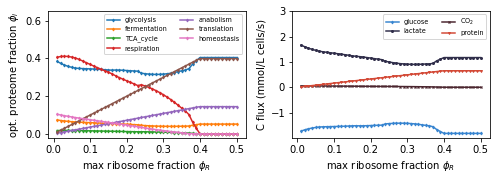

In [10]:
# Plot the proteome fractions as a function of the max ribosome fraction
fig, axs = plt.subplots(ncols=2, figsize=(7,2.6))

plt.sca(axs[0])
for c in opt_phis.columns:
    plt.plot(max_phi_rs, opt_phis[c], label=c, marker='d', markersize=2)
    
miny, maxy = plt.ylim()
plt.ylim(miny, 0.65)
plt.legend(loc='best', framealpha=0.8, ncols=2, fontsize=6.5)
plt.ylabel('opt. proteome fraction $\phi_i$', fontsize=10)
plt.xlabel('max ribosome fraction $\phi_R$', fontsize=10)

plt.sca(axs[1])
c_fluxes = opt_js*lam.m_df.NC
markers = 'doxvs3*'
pretty_names = dict(
    nutrient='glucose', fermentation_product='lactate',
    respiration_product='CO$_2$', protein='protein')
pal = sns.color_palette("icefire", n_colors=4) 
j = 0
for i, (idx, row) in enumerate(lam.m_df.iterrows()):
    vals = all_met_fluxes[:,i,:]
    total_flux_C = vals.sum(axis=0)*row.NC   
    if (np.abs(total_flux_C) < 1e-8).all():
        continue
    plt.plot(max_phi_rs, 100*total_flux_C, label=pretty_names[idx], 
             color=pal[j], marker=markers[j], markersize=2)
    j += 1

ymin, ymax = plt.ylim()
plt.ylim(ymin, 3)
plt.legend(loc='best', framealpha=0.8, ncols=2, fontsize=6.5)
plt.ylabel('C flux (mmol/L cells/s)')
plt.xlabel('max ribosome fraction $\phi_R$', fontsize=10)

plt.tight_layout()
plt.savefig('../output/linear_model_max_phi_R.png', facecolor='w', dpi=600)
plt.show()

# Not sure what leads to that discontinuity...

In [11]:
# Solve the problem at different dNOSC
soln_phis_nosc = []

dNOSCs = np.arange(-0.1, 1, 0.025)
max_mus = []
for d in dNOSCs:
    lam.set_dNOSC(d)
    
    mu_max, opt_prob = lam.maximize_mu()
    soln_phis_nosc.append(opt_prob.var_dict['phis'].value.copy())
    max_mus.append(mu_max)
    
opt_phis_nosc = pd.DataFrame(np.vstack(soln_phis_nosc), columns=lam.S_df.index)
max_mus = np.array(max_mus)

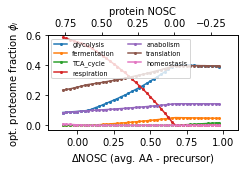

In [12]:
plt.figure(figsize=(3.5,2.5))
for c in opt_phis_nosc.columns:
    plt.plot(dNOSCs, opt_phis_nosc[c], label=c, marker='o', markersize=2)
    
miny, maxy = plt.ylim()
plt.ylim(miny, 0.6)
plt.legend(loc='best', fontsize=6.5, ncols=2, framealpha=0.8)
plt.xlabel('$\Delta$NOSC (avg. AA - precursor)', fontsize=10)
plt.ylabel('opt. proteome fraction $\phi_i$', fontsize=10)

xlim = np.array([-0.2, 1.1])
plt.xlim(xlim)

plt.twiny()
plt.xlim(-xlim+2/3)
plt.xlabel('protein NOSC')

plt.tight_layout()
plt.savefig('../output/linear_model_NOSC.png', facecolor='w', dpi=600)
plt.show()

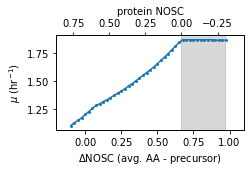

In [13]:
plt.figure(figsize=(3.5,2.5))
plt.plot(dNOSCs, max_mus, marker='o', markersize=2)
    
plt.xlabel('$\Delta$NOSC (avg. AA - precursor)', fontsize=10)
plt.ylabel('$\mu$ (hr$^{-1}$)', fontsize=10)

# Show the E. coli genomic range 
# Pyruvate = +2/3
# CDS range from ≈ 0 to -0.3
min_x = 2/3
max_x = 0.3 + 2/3
plt.axvspan(min_x, max_x, color='grey', alpha=0.3)
xlim = np.array([-0.2, 1.1])
plt.xlim(xlim)

plt.twiny()
plt.xlim(-xlim+2/3)
plt.xlabel('protein NOSC')

plt.tight_layout()
plt.savefig('../output/linear_model_NOSC_growth_rate.png', facecolor='w', dpi=600)
plt.show()

# Something is up here. Why is the value of protein NOSC = 0 special? 
# Seems like this is too coincidental. Need to dig in here.